In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math # For positional encoding

# --- 1. Data loading and preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
            'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

df_wide = pd.DataFrame()
for feat in features:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features:
        if feat != 'returns':
            col = f"{asset}_{feat}"
            if col in df_wide.columns:
                feature_cols.append(col)
features_data = df_wide[feature_cols]

scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features_data.values)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
window_size = 30

# --- 2. PCA dimensionality reduction ---
pca_components = 7
pca = PCA(n_components=pca_components)
features_pca = pca.fit_transform(features_scaled)

# --- 3. Generate improved dynamic portfolio weights incorporating risk ---
def risk_parity_weights(returns_window):
    cov = np.cov(returns_window.T)
    vol = np.sqrt(np.diag(cov))
    inv_vol = 1.0 / (vol + 1e-8)
    weights = inv_vol / inv_vol.sum()
    return weights

def generate_dynamic_weights_with_risk(returns_df, window=window_size):
    weights_list = []
    for i in range(len(returns_df) - 2*window):
        train_w = returns_df.iloc[i:i+window].values
        test_w = returns_df.iloc[i+window:i+2*window]
        mean_returns = test_w.mean()
        mean_returns[mean_returns < 0] = 0
        r_weights = risk_parity_weights(train_w)
        combined = mean_returns * r_weights
        combined[combined < 0] = 0
        if combined.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = combined / combined.sum()
        weights_list.append(weights)
    return np.array(weights_list)

dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

# --- 4. Create sequences with clipped and standardized Sharpe ratio targets ---
def standardize_targets(y):
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
    return y_scaled, scaler

def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
    X, y_sharpe, y_weights = [], [], []
    limit = len(features_data) - 2*window
    for i in range(limit):
        seq_x = features_data[i:i+window]
        returns_w = returns_data.iloc[i+window:i+2*window]
        mean_ret = returns_w.mean().mean()
        std_ret = returns_w.std().mean()
        sharpe = mean_ret / (std_ret + 1e-6)
        if clip_sharpe:
            sharpe = np.clip(sharpe, -5, 5)
        weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets))/len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    y_sharpe_arr = np.array(y_sharpe)
    y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
    return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window_size)

# --- 5. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 6. Hybrid Transformer + BiLSTM Model Definition ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)].detach() # detach to not update positional encoding
        return x

class HybridTransformerBiLSTM(nn.Module):
    def __init__(self, pca_components, n_assets, d_model=64, nhead=8, num_transformer_layers=2, lstm_hidden=64):
        super().__init__()
        # Project PCA features to d_model for Transformer
        self.input_proj = nn.Linear(pca_components, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_transformer_layers)

        # BiLSTM takes output of Transformer
        self.bilstm = nn.LSTM(input_size=d_model, hidden_size=lstm_hidden, batch_first=True, bidirectional=True)
        
        # Shared FC layer
        self.fc_shared = nn.Linear(lstm_hidden * 2, 128) # lstm_hidden*2 because bidirectional
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        # Output heads
        self.sharpe_out = nn.Linear(128, 1)
        self.weights_out = nn.Linear(128, n_assets)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x shape: (batch, seq_len, pca_components)
        
        # 1. Input Projection and Positional Encoding
        x = self.input_proj(x) # -> (batch, seq_len, d_model)
        x = self.pos_encoder(x) # Add positional info

        # 2. Transformer Encoder (expects (seq_len, batch, d_model))
        x = x.permute(1, 0, 2) # Permute for Transformer input
        transformer_output = self.transformer_encoder(x) # -> (seq_len, batch, d_model)
        x = transformer_output.permute(1, 0, 2) # Permute back for BiLSTM (batch, seq_len, d_model)

        # 3. BiLSTM
        lstm_out, _ = self.bilstm(x) # -> (batch, seq_len, lstm_hidden*2)
        
        # 4. Take last step of BiLSTM output
        last_step = lstm_out[:, -1, :] # -> (batch, lstm_hidden*2)

        # 5. Shared FC layer
        feat = self.relu(self.fc_shared(last_step))
        feat = self.dropout(feat)

        # 6. Output heads
        sharpe = self.sharpe_out(feat)
        weights = self.softmax(self.weights_out(feat))
        
        return sharpe, weights

model = HybridTransformerBiLSTM(
    pca_components=pca_components, 
    n_assets=len(assets), 
    d_model=64, # Dimension of attention inputs/outputs
    nhead=4, # Number of attention heads
    num_transformer_layers=2, # Number of transformer encoder layers
    lstm_hidden=64 # Hidden size of the BiLSTM
).to(device)


# --- 7. Training setup ---
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# --- 8. Training loop ---
epochs = 50
model.train()
start_time = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
        optimizer.zero_grad()

        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe * 0.1 + loss_weights

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

train_time = time.time() - start_time
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start


# --- 9. Model evaluation ---
model.eval()
all_pred_sharpe = []
all_true_sharpe = []
all_pred_weights = []
all_true_weights = []

with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_weights = np.vstack(all_true_weights)

# Inverse transform Sharpe ratios to original scale
pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

# Portfolio returns from predicted weights
test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)

# Turnover
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))


# Metrics definitions
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std > 0 else np.nan

def calmar_ratio(returns, period_per_year=252):
    returns = pd.Series(returns)
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (period_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown > 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    periods_per_year = 252
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns)

print("\n--- Portfolio Performance with Hybrid Transformer + BiLSTM + PCA ---")
print(f"Training time (seconds): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}\n")

for metric, value in performance_metrics.items():
    if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
        print(f"- {metric}: {value*100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Prediction MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Prediction MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Prediction R2: {r2_sharpe:.4f}")

# Save weights for plotting or further analysis
weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# weights_df.to_csv('hybrid_transformer_bilstm_pca_portfolio_weights.csv')
print("Saved predicted portfolio weights to 'hybrid_transformer_bilstm_pca_portfolio_weights.csv'.")


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.098901
Epoch 2/50, Loss: 0.064161
Epoch 3/50, Loss: 0.051586
Epoch 4/50, Loss: 0.037780
Epoch 5/50, Loss: 0.032292
Epoch 6/50, Loss: 0.029847
Epoch 7/50, Loss: 0.026395
Epoch 8/50, Loss: 0.026420
Epoch 9/50, Loss: 0.024640
Epoch 10/50, Loss: 0.022652
Epoch 11/50, Loss: 0.020686
Epoch 12/50, Loss: 0.018812
Epoch 13/50, Loss: 0.018193
Epoch 14/50, Loss: 0.018542
Epoch 15/50, Loss: 0.016880
Epoch 16/50, Loss: 0.016664
Epoch 17/50, Loss: 0.015310
Epoch 18/50, Loss: 0.015191
Epoch 19/50, Loss: 0.014694
Epoch 20/50, Loss: 0.014010
Epoch 21/50, Loss: 0.013848
Epoch 22/50, Loss: 0.013326
Epoch 23/50, Loss: 0.012690
Epoch 24/50, Loss: 0.012844
Epoch 25/50, Loss: 0.013658
Epoch 26/50, Loss: 0.012314
Epoch 27/50, Loss: 0.012165
Epoch 28/50, Loss: 0.011862
Epoch 29/50, Loss: 0.011700
Epoch 30/50, Loss: 0.012131
Epoch 31/50, Loss: 0.012342
Epoch 32/50, Loss: 0.011770
Epoch 33/50, Loss: 0.011093
Epoch 34/50, Loss: 0.011112
Epoch 35/50, Loss: 0.011171
Epoch 36/50, Loss: 0.010973
E

In [4]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import time
# import psutil
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import math

# # --- 1. Load and prepare raw data ---
# data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
# data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
# data = data.dropna(subset=['Date'])
# data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

# assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
# features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
#             'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# # Construct wide dataframe
# df_wide = pd.DataFrame()
# for feat in features:
#     temp = data.pivot(index='Date', columns='Ticker', values=feat)
#     temp.columns = [f"{col}_{feat}" for col in temp.columns]
#     df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp
# df_wide = df_wide.dropna()

# returns_cols = [f"{asset}_returns" for asset in assets]
# etf_returns = df_wide[returns_cols]

# feature_cols = []
# for asset in assets:
#     for feat in features:
#         if feat != 'returns':
#             col = f"{asset}_{feat}"
#             if col in df_wide.columns:
#                 feature_cols.append(col)
# features_data = df_wide[feature_cols]

# scaler_features = StandardScaler()
# features_scaled = scaler_features.fit_transform(features_data.values)

# # --- 2. PCA for dimensionality reduction ---
# pca_components = 7
# pca = PCA(n_components=pca_components)
# features_pca = pca.fit_transform(features_scaled)

# window_size = 30

# # --- 3. Generate improved dynamic portfolio weights incorporating risk ---
# def risk_parity_weights(returns_window):
#     cov = np.cov(returns_window.T)
#     vol = np.sqrt(np.diag(cov))
#     inv_vol = 1.0 / (vol + 1e-8)
#     weights = inv_vol / inv_vol.sum()
#     return weights

# def generate_dynamic_weights_with_risk(returns_df, window=window_size):
#     weights_list = []
#     for i in range(len(returns_df) - 2*window):
#         train_w = returns_df.iloc[i:i+window].values
#         test_w = returns_df.iloc[i+window:i+2*window]
#         mean_returns = test_w.mean()
#         mean_returns[mean_returns < 0] = 0
#         r_weights = risk_parity_weights(train_w)
#         combined = mean_returns * r_weights
#         combined[combined < 0] = 0
#         if combined.sum() == 0:
#             weights = np.ones(len(mean_returns)) / len(mean_returns)
#         else:
#             weights = combined / combined.sum()
#         weights_list.append(weights)
#     return np.array(weights_list)

# dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

# # --- 4. Create sequences with clipped and standardized Sharpe ratio targets ---
# def standardize_targets(y):
#     scaler = StandardScaler()
#     y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
#     return y_scaled, scaler

# def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
#     X, y_sharpe, y_weights = [], [], []
#     limit = len(features_data) - 2*window
#     for i in range(limit):
#         seq_x = features_data[i:i+window]
#         returns_w = returns_data.iloc[i+window:i+2*window]
#         mean_ret = returns_w.mean().mean()
#         std_ret = returns_w.std().mean()
#         sharpe = mean_ret / (std_ret + 1e-6)
#         if clip_sharpe:
#             sharpe = np.clip(sharpe, -5, 5)
#         weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets))/len(assets)
#         X.append(seq_x)
#         y_sharpe.append(sharpe)
#         y_weights.append(weight_target)
#     y_sharpe_arr = np.array(y_sharpe)
#     y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
#     return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

# X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window_size)

# # --- 5. Dataset and DataLoader ---
# class PortfolioDataset(Dataset):
#     def __init__(self, X, y_sharpe, y_weights):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
#         self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
#     def __len__(self):
#         return len(self.X)
#     def __getitem__(self, idx):
#         return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

# X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
#     X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

# train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
# test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32)

# # --- 6. Transformer Model Definition ---
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1).float()
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)
#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1)].detach()
#         return x

# class TransformerPortfolioModel(nn.Module):
#     def __init__(self, pca_components, n_assets, d_model=64, nhead=8, num_encoder_layers=4):
#         super().__init__()
#         self.input_proj = nn.Linear(pca_components, d_model)
#         self.pos_encoder = PositionalEncoding(d_model)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256, dropout=0.1)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
#         self.fc_shared = nn.Linear(d_model, 128)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)
#         self.sharpe_out = nn.Linear(128, 1)
#         self.weights_out = nn.Linear(128, n_assets)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.input_proj(x)                  # (batch, seq_len, d_model)
#         x = self.pos_encoder(x)                 # add positional encoding
#         x = x.permute(1, 0, 2)                  # transformer expects (seq_len, batch, d_model)
#         x = self.transformer_encoder(x)
#         x = x.permute(1, 0, 2)                  # back to (batch, seq_len, d_model)
#         last_step = x[:, -1, :]                 # take last timestep output
#         feat = self.relu(self.fc_shared(last_step))
#         feat = self.dropout(feat)
#         sharpe = self.sharpe_out(feat)
#         weights = self.softmax(self.weights_out(feat))
#         return sharpe, weights

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TransformerPortfolioModel(pca_components=pca_components, n_assets=len(assets)).to(device)

# # --- 7. Training setup ---
# criterion_sharpe = nn.MSELoss()
# criterion_weights = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # --- 8. Training loop ---
# epochs = 50
# model.train()
# start_time = time.time()
# cpu_start = psutil.cpu_percent(interval=None)

# for epoch in range(epochs):
#     epoch_loss = 0
#     for batch_x, batch_sharpe, batch_weights in train_loader:
#         batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
#         optimizer.zero_grad()
#         pred_sharpe, pred_weights = model(batch_x)
#         loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
#         loss_weights = criterion_weights(pred_weights, batch_weights)
#         loss = loss_sharpe * 0.1 + loss_weights
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

# train_time = time.time() - start_time
# cpu_end = psutil.cpu_percent(interval=None)
# cpu_usage = cpu_end - cpu_start

# # --- 9. Evaluation ---
# model.eval()
# all_pred_sharpe, all_true_sharpe = [], []
# all_pred_weights, all_true_weights = [], []

# with torch.no_grad():
#     for batch_x, batch_sharpe, batch_weights in test_loader:
#         batch_x = batch_x.to(device)
#         pred_sharpe, pred_weights = model(batch_x)
#         all_pred_sharpe.append(pred_sharpe.cpu().numpy())
#         all_pred_weights.append(pred_weights.cpu().numpy())
#         all_true_sharpe.append(batch_sharpe.cpu().numpy())
#         all_true_weights.append(batch_weights.cpu().numpy())

# pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
# true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
# pred_weights = np.vstack(all_pred_weights)
# pred_weights /= pred_weights.sum(axis=1, keepdims=True)
# true_weights = np.vstack(all_true_weights)

# pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
# true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

# test_returns = etf_returns.iloc[-len(pred_weights):].values
# portfolio_returns = np.sum(test_returns * pred_weights, axis=1)

# turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# # Metrics functions
# def sortino_ratio(returns, risk_free=0, periods_per_year=252):
#     returns = pd.Series(returns)
#     downside = returns[returns < risk_free]
#     expected_return = returns.mean() * periods_per_year
#     downside_std = downside.std() * np.sqrt(periods_per_year)
#     return expected_return / downside_std if downside_std > 0 else np.nan

# def calmar_ratio(returns, periods_per_year=252):
#     returns = pd.Series(returns)
#     cumulative = (1 + returns).cumprod()
#     annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
#     max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
#     return annualized_return / max_drawdown if max_drawdown > 0 else np.nan

# mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
# mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
# r2_sharpe = r2_score(true_sharpe, pred_sharpe)
# sortino = sortino_ratio(portfolio_returns)
# calmar = calmar_ratio(portfolio_returns)

# def evaluate_portfolio_performance(returns):
#     returns = pd.Series(returns).replace([np.inf, -np.inf], np.nan).dropna()
#     periods_per_year = 252
#     portfolio_vals = (1 + returns).cumprod()
#     peak = portfolio_vals.cummax()
#     drawdown = (peak - portfolio_vals) / peak
#     max_drawdown = drawdown.max()
#     total_periods = len(returns)
#     annualized_return = (portfolio_vals.iloc[-1]) ** (periods_per_year / total_periods) - 1
#     annualized_volatility = returns.std() * np.sqrt(periods_per_year)
#     mean_return = returns.mean() * periods_per_year
#     sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
#     return {
#         'Sharpe Ratio': sharpe_ratio,
#         'Annualized Return': annualized_return,
#         'Annualized Volatility': annualized_volatility,
#         'Max Drawdown': max_drawdown
#     }

# performance_metrics = evaluate_portfolio_performance(portfolio_returns)

# print("\n--- Portfolio Performance with Transformer + PCA ---")
# print(f"Training time (seconds): {train_time:.2f}")
# print(f"CPU usage change (%): {cpu_usage:.2f}\n")

# for metric, value in performance_metrics.items():
#     if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
#         print(f"- {metric}: {value*100:.2f}%")
#     else:
#         print(f"- {metric}: {value:.4f}")

# print(f"- Sortino Ratio: {sortino:.4f}")
# print(f"- Calmar Ratio: {calmar:.4f}")
# print(f"- Average Turnover: {turnover:.4f}")
# print(f"- Sharpe Prediction MSE: {mse_sharpe:.6f}")
# print(f"- Sharpe Prediction MAE: {mae_sharpe:.6f}")
# print(f"- Sharpe Prediction R2: {r2_sharpe:.4f}")

# # Save predicted portfolio weights for further analysis
# weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# # weights_df.to_csv('transformer_pca_portfolio_weights.csv')
# print("Saved predicted portfolio weights to 'transformer_pca_portfolio_weights.csv'.")


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.103223
Epoch 2/50, Loss: 0.079605
Epoch 3/50, Loss: 0.061359
Epoch 4/50, Loss: 0.048255
Epoch 5/50, Loss: 0.041548
Epoch 6/50, Loss: 0.037400
Epoch 7/50, Loss: 0.032166
Epoch 8/50, Loss: 0.031965
Epoch 9/50, Loss: 0.028608
Epoch 10/50, Loss: 0.027829
Epoch 11/50, Loss: 0.025107
Epoch 12/50, Loss: 0.023649
Epoch 13/50, Loss: 0.023523
Epoch 14/50, Loss: 0.021787
Epoch 15/50, Loss: 0.020385
Epoch 16/50, Loss: 0.020063
Epoch 17/50, Loss: 0.019108
Epoch 18/50, Loss: 0.018567
Epoch 19/50, Loss: 0.018431
Epoch 20/50, Loss: 0.019053
Epoch 21/50, Loss: 0.017948
Epoch 22/50, Loss: 0.016586
Epoch 23/50, Loss: 0.016485
Epoch 24/50, Loss: 0.017021
Epoch 25/50, Loss: 0.015957
Epoch 26/50, Loss: 0.015297
Epoch 27/50, Loss: 0.016478
Epoch 28/50, Loss: 0.015559
Epoch 29/50, Loss: 0.014718
Epoch 30/50, Loss: 0.014286
Epoch 31/50, Loss: 0.013570
Epoch 32/50, Loss: 0.013877
Epoch 33/50, Loss: 0.013336
Epoch 34/50, Loss: 0.014026
Epoch 35/50, Loss: 0.013987
Epoch 36/50, Loss: 0.014014
E

In [6]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import time
# import psutil
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import math

# # --- 1. Load and prepare raw data ---
# data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
# data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
# data = data.dropna(subset=['Date'])
# data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

# assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
# features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14',
#             'Calmar_Ratio_21','ATR_14','Open','Close','High','nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']

# df_wide = pd.DataFrame()
# for feat in features:
#     temp = data.pivot(index='Date', columns='Ticker', values=feat)
#     temp.columns = [f"{col}_{feat}" for col in temp.columns]
#     df_wide = pd.concat([df_wide, temp], axis=1) if not df_wide.empty else temp

# df_wide = df_wide.dropna()

# returns_cols = [f"{asset}_returns" for asset in assets]
# etf_returns = df_wide[returns_cols]

# feature_cols = []
# for asset in assets:
#     for feat in features:
#         if feat != 'returns':
#             col = f"{asset}_{feat}"
#             if col in df_wide.columns:
#                 feature_cols.append(col)
# features_data = df_wide[feature_cols]

# scaler_features = StandardScaler()
# features_scaled = scaler_features.fit_transform(features_data.values)

# # --- 2. PCA dimensionality reduction ---
# pca_components = 7
# pca = PCA(n_components=pca_components)
# features_pca = pca.fit_transform(features_scaled)

# window_size = 30

# # --- 3. Generate improved dynamic portfolio weights incorporating risk ---
# def risk_parity_weights(returns_window):
#     cov = np.cov(returns_window.T)
#     vol = np.sqrt(np.diag(cov))
#     inv_vol = 1.0 / (vol + 1e-8)
#     weights = inv_vol / inv_vol.sum()
#     return weights

# def generate_dynamic_weights_with_risk(returns_df, window=window_size):
#     weights_list = []
#     for i in range(len(returns_df) - 2*window):
#         train_w = returns_df.iloc[i:i+window].values
#         test_w = returns_df.iloc[i+window:i+2*window]
#         mean_returns = test_w.mean()
#         mean_returns[mean_returns < 0] = 0
#         r_weights = risk_parity_weights(train_w)
#         combined = mean_returns * r_weights
#         combined[combined < 0] = 0
#         if combined.sum() == 0:
#             weights = np.ones(len(mean_returns)) / len(mean_returns)
#         else:
#             weights = combined / combined.sum()
#         weights_list.append(weights)
#     return np.array(weights_list)

# dynamic_weights = generate_dynamic_weights_with_risk(etf_returns, window=window_size)

# # --- 4. Create sequences with clipped and standardized Sharpe ratio targets ---
# def standardize_targets(y):
#     scaler = StandardScaler()
#     y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()
#     return y_scaled, scaler

# def create_sequences(features_data, returns_data, weights_data, window, clip_sharpe=True):
#     X, y_sharpe, y_weights = [], [], []
#     limit = len(features_data) - 2*window
#     for i in range(limit):
#         seq_x = features_data[i:i+window]
#         returns_w = returns_data.iloc[i+window:i+2*window]
#         mean_ret = returns_w.mean().mean()
#         std_ret = returns_w.std().mean()
#         sharpe = mean_ret / (std_ret + 1e-6)
#         if clip_sharpe:
#             sharpe = np.clip(sharpe, -5, 5)
#         weight_target = weights_data[i] if i < len(weights_data) else np.ones(len(assets)) / len(assets)
#         X.append(seq_x)
#         y_sharpe.append(sharpe)
#         y_weights.append(weight_target)
#     y_sharpe_arr = np.array(y_sharpe)
#     y_sharpe_scaled, scaler = standardize_targets(y_sharpe_arr)
#     return np.array(X), y_sharpe_scaled, np.array(y_weights), scaler

# X, y_sharpe_scaled, y_weights, sharpe_scaler = create_sequences(features_pca, etf_returns, dynamic_weights, window_size)

# # --- 5. Dataset and DataLoader ---
# class PortfolioDataset(Dataset):
#     def __init__(self, X, y_sharpe, y_weights):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
#         self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
#     def __len__(self):
#         return len(self.X)
#     def __getitem__(self, idx):
#         return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

# X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
#     X, y_sharpe_scaled, y_weights, test_size=0.2, random_state=42)

# train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
# test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32)

# # --- 6. Transformer + CNN hybrid model definition ---
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_len=5000):
#         super().__init__()
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1).float()
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1)].detach()
#         return x

# class TransformerCNNPortfolioModel(nn.Module):
#     def __init__(self, pca_components, n_assets, d_model=64, nhead=8, num_encoder_layers=3,
#                  cnn_channels=[64, 64], cnn_kernel_size=3, cnn_dropout=0.2):
#         super().__init__()
#         # Project PCA features to d_model
#         self.input_proj = nn.Linear(pca_components, d_model)
#         self.pos_encoder = PositionalEncoding(d_model)

#         encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256, dropout=0.1)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

#         # CNN layers operate on Transformer output features
#         cnn_layers = []
#         in_channels = d_model
#         for out_channels in cnn_channels:
#             cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=cnn_kernel_size, padding=cnn_kernel_size // 2))
#             cnn_layers.append(nn.BatchNorm1d(out_channels))
#             cnn_layers.append(nn.ReLU())
#             cnn_layers.append(nn.Dropout(cnn_dropout))
#             in_channels = out_channels
#         self.cnn = nn.Sequential(*cnn_layers)

#         self.fc_shared = nn.Linear(cnn_channels[-1], 128)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.3)

#         self.sharpe_out = nn.Linear(128, 1)
#         self.weights_out = nn.Linear(128, n_assets)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # x: (batch, seq_len, pca_components)
#         x = self.input_proj(x)            # (batch, seq_len, d_model)
#         x = self.pos_encoder(x)           # add positional encoding
#         x = x.permute(1, 0, 2)            # (seq_len, batch, d_model) for transformer
#         x = self.transformer_encoder(x)
#         x = x.permute(1, 2, 0)            # (batch, d_model, seq_len) for CNN

#         x = self.cnn(x)                   # CNN layers output shape (batch, out_channels, seq_len)
#         x = x.mean(dim=2)                 # Global average pooling over seq_len -> (batch, out_channels)

#         feat = self.relu(self.fc_shared(x))
#         feat = self.dropout(feat)

#         sharpe = self.sharpe_out(feat)
#         weights = self.softmax(self.weights_out(feat))
#         return sharpe, weights

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = TransformerCNNPortfolioModel(pca_components=pca_components, n_assets=len(assets)).to(device)

# # --- 7. Training setup ---
# criterion_sharpe = nn.MSELoss()
# criterion_weights = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # --- 8. Training loop ---
# epochs = 50
# model.train()
# start_time = time.time()
# cpu_start = psutil.cpu_percent(interval=None)

# for epoch in range(epochs):
#     epoch_loss = 0
#     for batch_x, batch_sharpe, batch_weights in train_loader:
#         batch_x, batch_sharpe, batch_weights = batch_x.to(device), batch_sharpe.to(device), batch_weights.to(device)
#         optimizer.zero_grad()
#         pred_sharpe, pred_weights = model(batch_x)
#         loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
#         loss_weights = criterion_weights(pred_weights, batch_weights)
#         loss = loss_sharpe * 0.1 + loss_weights
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

# train_time = time.time() - start_time
# cpu_end = psutil.cpu_percent(interval=None)
# cpu_usage = cpu_end - cpu_start

# # --- 9. Evaluation ---
# model.eval()
# all_pred_sharpe, all_true_sharpe = [], []
# all_pred_weights, all_true_weights = [], []

# with torch.no_grad():
#     for batch_x, batch_sharpe, batch_weights in test_loader:
#         batch_x = batch_x.to(device)
#         pred_sharpe, pred_weights = model(batch_x)
#         all_pred_sharpe.append(pred_sharpe.cpu().numpy())
#         all_pred_weights.append(pred_weights.cpu().numpy())
#         all_true_sharpe.append(batch_sharpe.cpu().numpy())
#         all_true_weights.append(batch_weights.cpu().numpy())

# pred_sharpe_scaled = np.vstack(all_pred_sharpe).flatten()
# true_sharpe_scaled = np.vstack(all_true_sharpe).flatten()
# pred_weights = np.vstack(all_pred_weights)
# pred_weights /= pred_weights.sum(axis=1, keepdims=True)
# true_weights = np.vstack(all_true_weights)

# pred_sharpe = sharpe_scaler.inverse_transform(pred_sharpe_scaled.reshape(-1,1)).flatten()
# true_sharpe = sharpe_scaler.inverse_transform(true_sharpe_scaled.reshape(-1,1)).flatten()

# test_returns = etf_returns.iloc[-len(pred_weights):].values
# portfolio_returns = np.sum(test_returns * pred_weights, axis=1)

# turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# # Metrics functions
# def sortino_ratio(returns, risk_free=0, periods_per_year=252):
#     returns = pd.Series(returns)
#     downside = returns[returns < risk_free]
#     expected_return = returns.mean() * periods_per_year
#     downside_std = downside.std() * np.sqrt(periods_per_year)
#     return expected_return / downside_std if downside_std > 0 else np.nan

# def calmar_ratio(returns, periods_per_year=252):
#     returns = pd.Series(returns)
#     cumulative = (1 + returns).cumprod()
#     annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
#     max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
#     return annualized_return / max_drawdown if max_drawdown > 0 else np.nan

# mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
# mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
# r2_sharpe = r2_score(true_sharpe, pred_sharpe)
# sortino = sortino_ratio(portfolio_returns)
# calmar = calmar_ratio(portfolio_returns)

# def evaluate_portfolio_performance(returns):
#     returns = pd.Series(returns).replace([np.inf, -np.inf], np.nan).dropna()
#     periods_per_year = 252
#     portfolio_vals = (1 + returns).cumprod()
#     peak = portfolio_vals.cummax()
#     drawdown = (peak - portfolio_vals) / peak
#     max_drawdown = drawdown.max()
#     total_periods = len(returns)
#     annualized_return = (portfolio_vals.iloc[-1]) ** (periods_per_year / total_periods) - 1
#     annualized_volatility = returns.std() * np.sqrt(periods_per_year)
#     mean_return = returns.mean() * periods_per_year
#     sharpe_ratio = mean_return / annualized_volatility if annualized_volatility > 0 else np.nan
#     return {
#         'Sharpe Ratio': sharpe_ratio,
#         'Annualized Return': annualized_return,
#         'Annualized Volatility': annualized_volatility,
#         'Max Drawdown': max_drawdown
#     }

# performance_metrics = evaluate_portfolio_performance(portfolio_returns)

# print("\n--- Portfolio Performance with Transformer + CNN + PCA ---")
# print(f"Training time (seconds): {train_time:.2f}")
# print(f"CPU usage change (%): {cpu_usage:.2f}\n")

# for metric, value in performance_metrics.items():
#     if "Return" in metric or "Volatility" in metric or "Drawdown" in metric:
#         print(f"- {metric}: {value*100:.2f}%")
#     else:
#         print(f"- {metric}: {value:.4f}")

# print(f"- Sortino Ratio: {sortino:.4f}")
# print(f"- Calmar Ratio: {calmar:.4f}")
# print(f"- Average Turnover: {turnover:.4f}")
# print(f"- Sharpe Prediction MSE: {mse_sharpe:.6f}")
# print(f"- Sharpe Prediction MAE: {mae_sharpe:.6f}")
# print(f"- Sharpe Prediction R2: {r2_sharpe:.4f}")

# # Save predicted portfolio weights for further analysis
# weights_df = pd.DataFrame(pred_weights, index=etf_returns.index[-len(pred_weights):], columns=assets)
# # weights_df.to_csv('transformer_cnn_pca_portfolio_weights.csv')
# print("Saved predicted portfolio weights to 'transformer_cnn_pca_portfolio_weights.csv'.")


/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.103033
Epoch 2/50, Loss: 0.080787
Epoch 3/50, Loss: 0.068522
Epoch 4/50, Loss: 0.060024
Epoch 5/50, Loss: 0.052086
Epoch 6/50, Loss: 0.044957
Epoch 7/50, Loss: 0.041494
Epoch 8/50, Loss: 0.039372
Epoch 9/50, Loss: 0.035705
Epoch 10/50, Loss: 0.034061
Epoch 11/50, Loss: 0.033338
Epoch 12/50, Loss: 0.032340
Epoch 13/50, Loss: 0.030383
Epoch 14/50, Loss: 0.027787
Epoch 15/50, Loss: 0.028346
Epoch 16/50, Loss: 0.026859
Epoch 17/50, Loss: 0.024809
Epoch 18/50, Loss: 0.025349
Epoch 19/50, Loss: 0.023175
Epoch 20/50, Loss: 0.023378
Epoch 21/50, Loss: 0.021562
Epoch 22/50, Loss: 0.020878
Epoch 23/50, Loss: 0.020420
Epoch 24/50, Loss: 0.020985
Epoch 25/50, Loss: 0.020151
Epoch 26/50, Loss: 0.019993
Epoch 27/50, Loss: 0.019308
Epoch 28/50, Loss: 0.019431
Epoch 29/50, Loss: 0.019406
Epoch 30/50, Loss: 0.019034
Epoch 31/50, Loss: 0.018765
Epoch 32/50, Loss: 0.017979
Epoch 33/50, Loss: 0.018193
Epoch 34/50, Loss: 0.017588
Epoch 35/50, Loss: 0.017131
Epoch 36/50, Loss: 0.017022
E

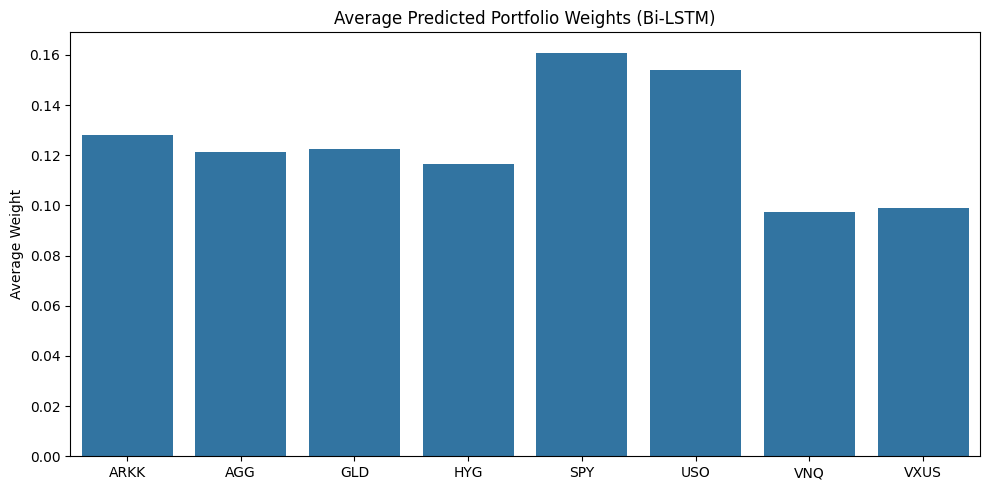

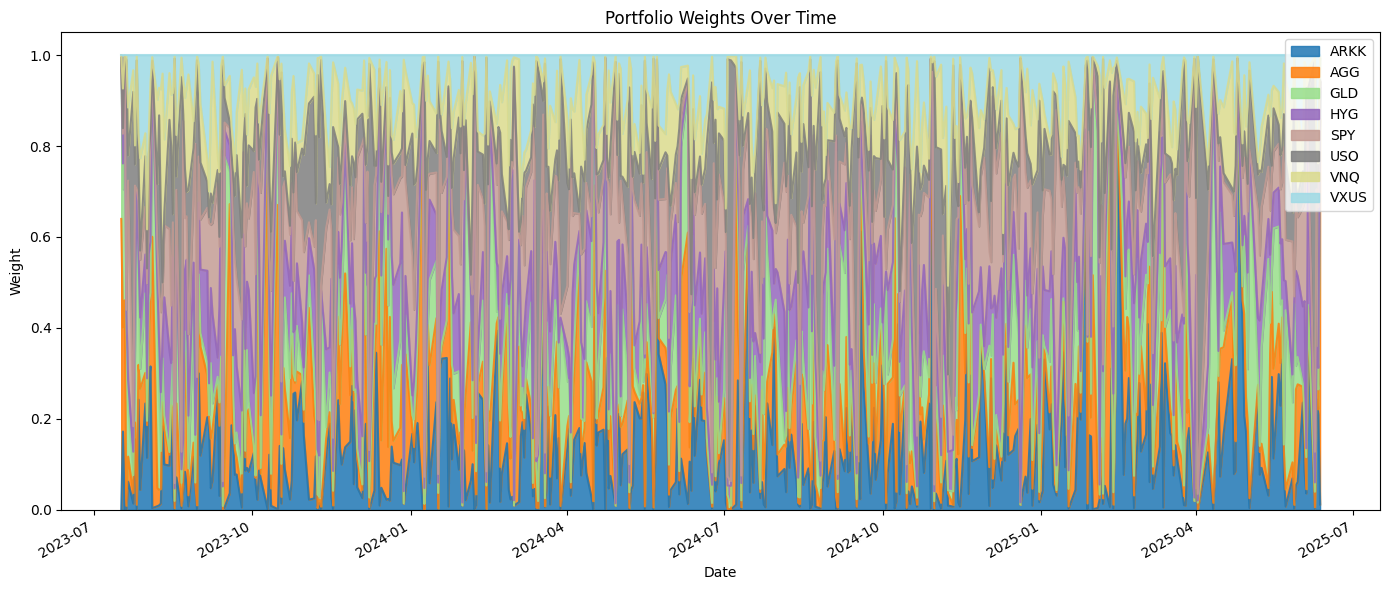

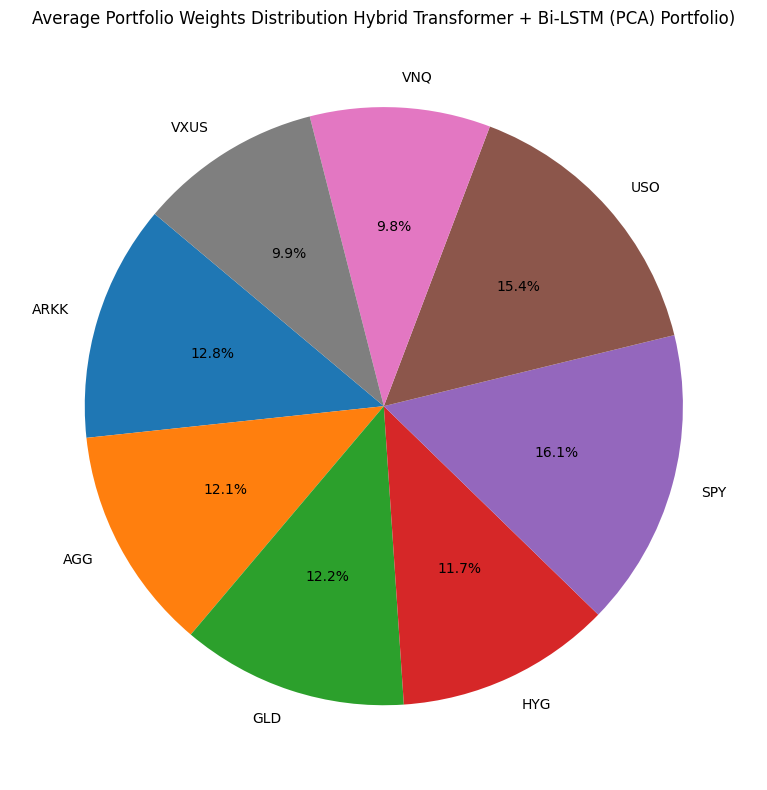

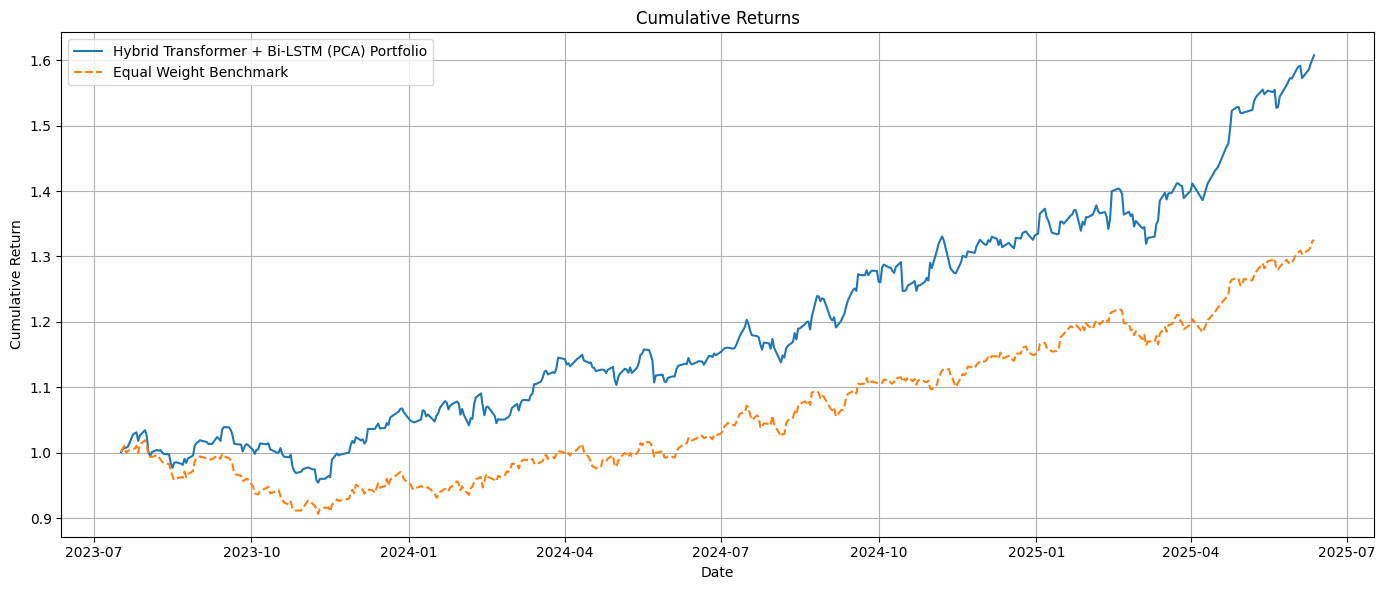

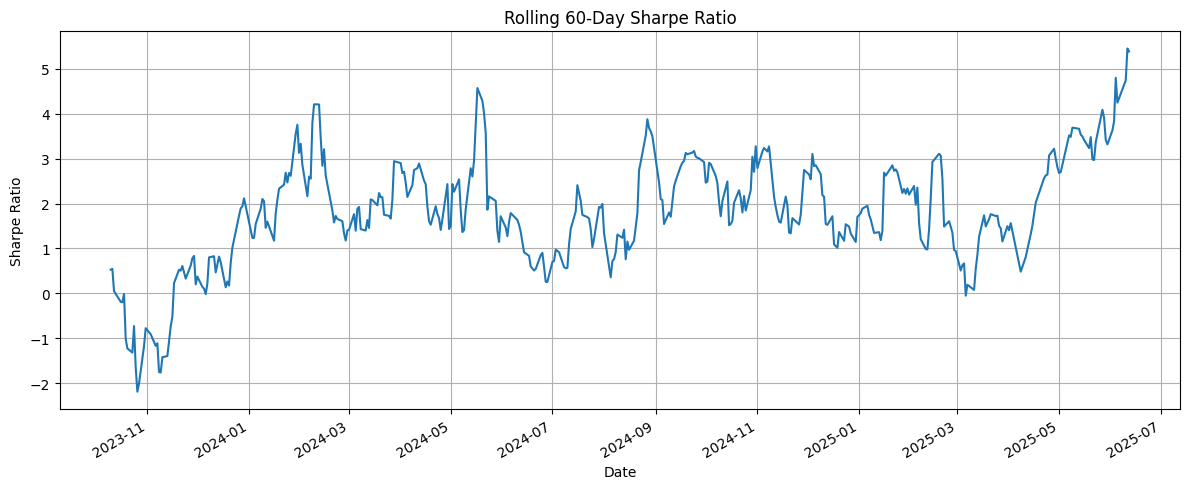

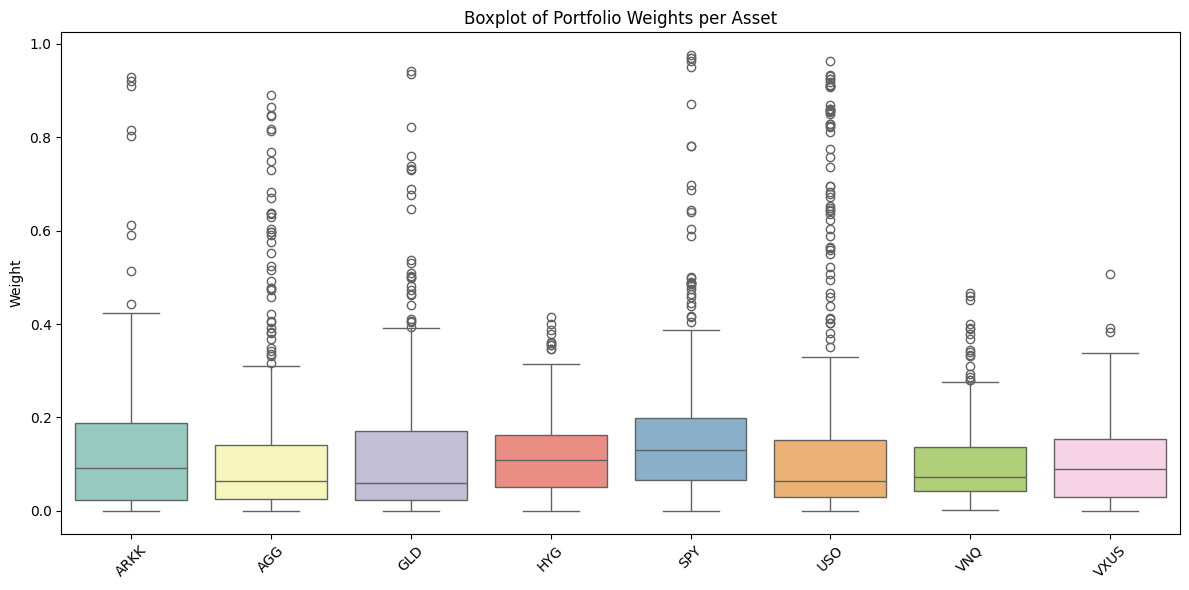

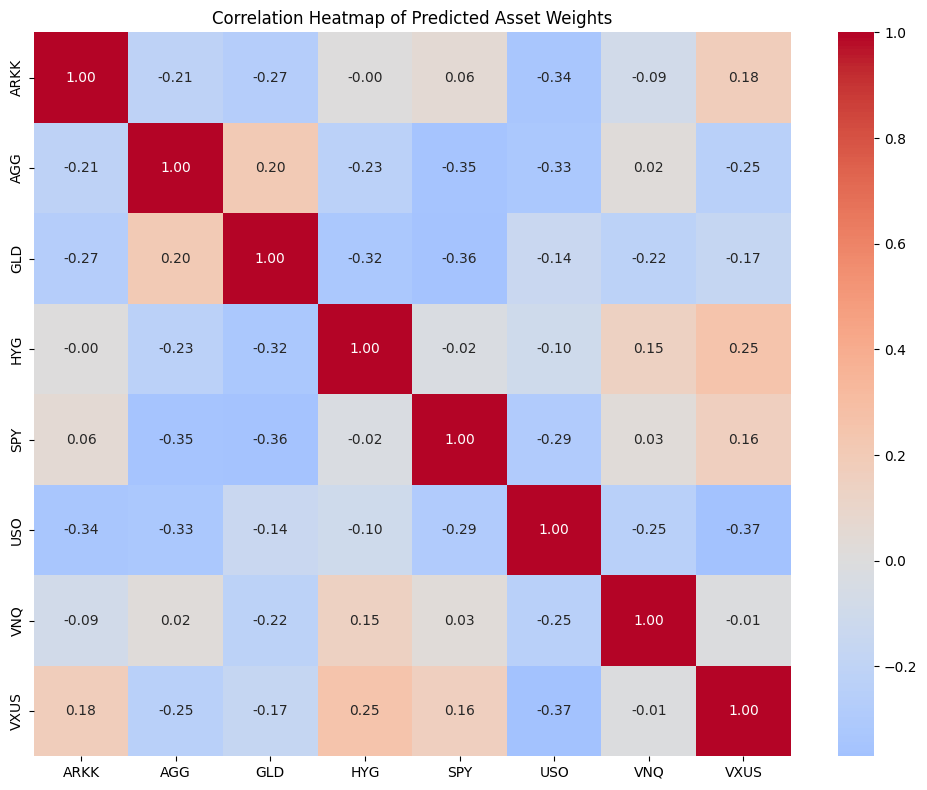

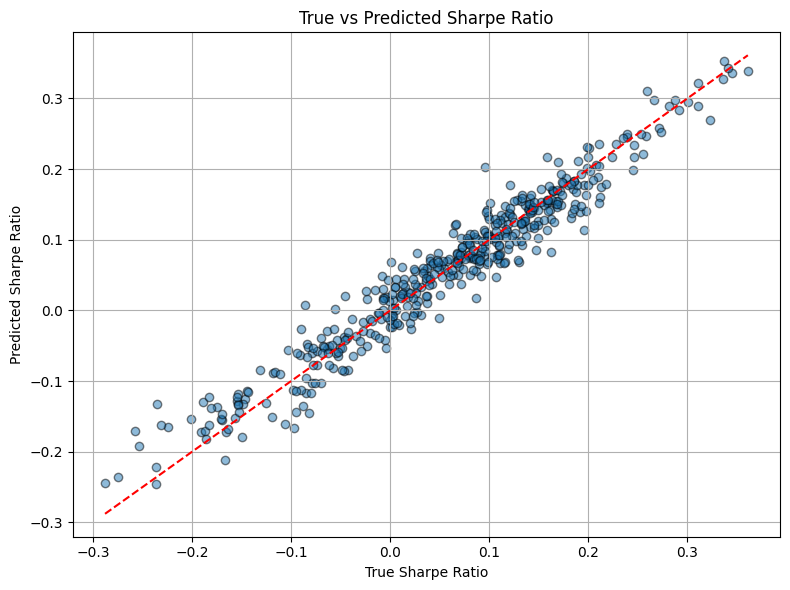

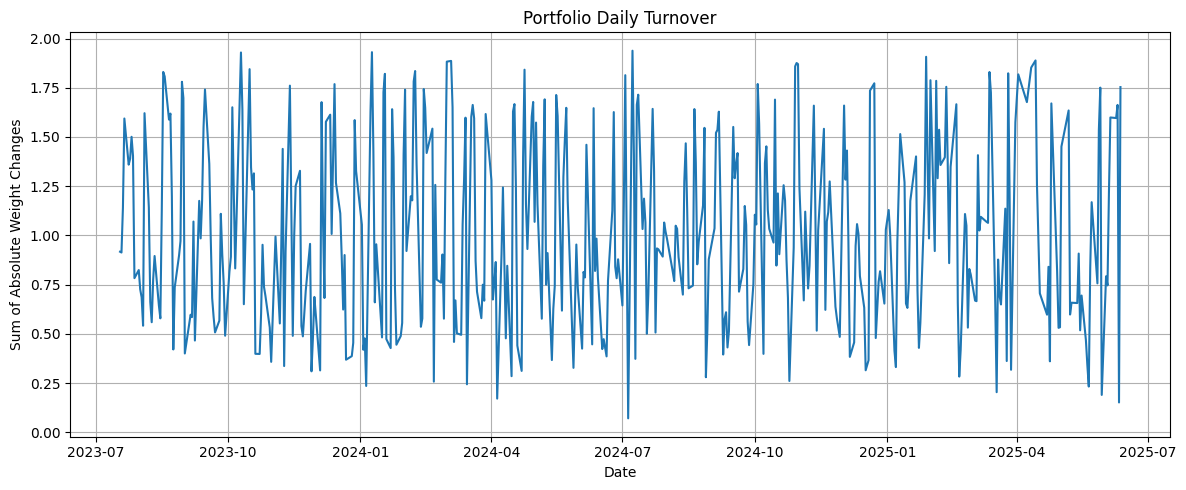

NameError: name 'drawdown' is not defined

<Figure size 1200x500 with 0 Axes>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# assuming the following variables are defined from your Bi-LSTM model and data:
# pred_weights (np.array): predicted portfolio weights, shape (time_steps, n_assets)
# true_sharpe (np.array): true Sharpe ratios for test samples
# pred_sharpe (np.array): predicted Sharpe ratios for test samples
# etf_returns (pd.DataFrame): aligned returns data for test period, shape (time_steps, n_assets)
# assets (list of str): asset tickers or names

# 1. Average Predicted Portfolio Weights (Bar Plot)
avg_weights = pred_weights.mean(axis=0)
plt.figure(figsize=(10,5))
sns.barplot(x=assets, y=avg_weights)
plt.title('Average Predicted Portfolio Weights (Bi-LSTM)')
plt.ylabel('Average Weight')
plt.tight_layout()
plt.show()

# 2. Stacked Area Chart: Portfolio Weights Over Time
pred_weights = pd.DataFrame(pred_weights, columns=assets, index=etf_returns.index[-len(pred_weights):])
pred_weights.plot.area(figsize=(14,6), cmap='tab20', alpha=0.85)
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# # 2. Portfolio Weights Over Time (Line Plot)
# plt.figure(figsize=(12,6))
# for asset in assets:
#     plt.plot(pred_weights.index, pred_weights[asset], label=asset)
# plt.title('Portfolio Weights Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('Weight')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 3. Pie Chart of Average Portfolio Weights
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=140)
plt.title('Average Portfolio Weights Distribution Hybrid Transformer + Bi-LSTM (PCA) Portfolio)')
plt.tight_layout()
plt.show()

# 3. Cumulative Returns of Portfolio vs Equal Weight Benchmark
portfolio_returns = np.sum(pred_weights * etf_returns.iloc[-len(pred_weights):].values, axis=1)
cumulative_portfolio = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()

equal_weight_returns = etf_returns.iloc[-len(pred_weights):].mean(axis=1)
cumulative_equal = (1 + equal_weight_returns).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cumulative_portfolio, label='Hybrid Transformer + Bi-LSTM (PCA) Portfolio')
plt.plot(cumulative_equal, label='Equal Weight Benchmark', linestyle='--')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Rolling Sharpe Ratio (60-day window)
rolling_window = 60
rolling_returns = pd.Series(portfolio_returns, index=weights_df.index).rolling(rolling_window)
rolling_sharpe = rolling_returns.mean() / (rolling_returns.std() + 1e-6) * np.sqrt(252)

plt.figure(figsize=(12,5))
rolling_sharpe.plot()
plt.title(f'Rolling {rolling_window}-Day Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 5. Histogram: Distribution of All Portfolio Weights
# plt.figure(figsize=(10,6))
# sns.histplot(pred_weights.flatten(), bins=50, kde=True, color='skyblue')
# plt.title('Distribution of Portfolio Weights')
# plt.xlabel('Weight')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

# 6. Boxplot: Portfolio Weights Per Asset
plt.figure(figsize=(12,6))
sns.boxplot(data=weights_df, palette='Set3')
plt.title('Boxplot of Portfolio Weights per Asset')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap: Asset Weights Correlation
plt.figure(figsize=(10,8))
corr_weights = weights_df.corr()
sns.heatmap(corr_weights, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Predicted Asset Weights')
plt.tight_layout()
plt.show()

# 8. Scatter Plot: True vs Predicted Sharpe Ratios
plt.figure(figsize=(8,6))
plt.scatter(true_sharpe, pred_sharpe, alpha=0.5, edgecolors='k')
plt.plot([true_sharpe.min(), true_sharpe.max()], [true_sharpe.min(), true_sharpe.max()], 'r--')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('True vs Predicted Sharpe Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Daily Portfolio Turnover Over Time
turnover = np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1)
plt.figure(figsize=(12,5))
plt.plot(weights_df.index[1:], turnover)
plt.title('Portfolio Daily Turnover')
plt.xlabel('Date')
plt.ylabel('Sum of Absolute Weight Changes')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 10. Drawdown Curve
# cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
# rolling_max = cum_returns.cummax()
# drawdown = (rolling_max - cum_returns) / rolling_max

plt.figure(figsize=(12,5))
drawdown.plot()
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Predicted vs True Sharpe Ratio Scatter Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=true_sharpe, y=pred_sharpe)
min_val = min(min(true_sharpe), min(pred_sharpe))
max_val = max(max(true_sharpe), max(pred_sharpe))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Predicted vs True Sharpe Ratio (Test Set)')
plt.xlabel('True Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.tight_layout()
plt.show()

# 5. Portfolio Cumulative Returns (Test Set)
cum_returns = (1 + pd.Series(portfolio_returns, index=weights_df.index)).cumprod()
plt.figure(figsize=(10,5))
plt.plot(cum_returns.index, cum_returns.values)
plt.title('Test Portfolio Cumulative Returns Hybrid Transformer + Bi-LSTM (PCA) Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Portfolio Drawdown Plot
peak = cum_returns.cummax()
drawdown = (peak - cum_returns) / peak
plt.figure(figsize=(10,5))
plt.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.3)
plt.title('Portfolio Drawdown Over Time Hybrid Transformer + Bi-LSTM (PCA) Portfolio')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# # 7. Heatmap of ETF Allocations Over Time
# plt.figure(figsize=(12,6))
# sns.heatmap(weights_df.T, xticklabels=weights_df.index.strftime('%Y-%m-%d'), yticklabels=assets, cmap='viridis')
# plt.title('Heatmap of ETF Allocation Over Time (CNN-LSTM)')
# plt.xlabel('Date')
# plt.ylabel('ETF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# 2. Bar Plot of Performance Metrics (MSE, MAE, R²)
metrics = ['MSE', 'MAE', 'R2']
values = [mse_sharpe, mae_sharpe, r2_sharpe]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette='muted')
plt.title('Sharpe Ratio Prediction Performance Metrics')
plt.ylabel('Metric Value')
plt.tight_layout()
plt.show()

# 3. Display Training Time and CPU Usage as Text Plot
plt.figure(figsize=(6,3))
plt.axis('off')
plt.text(0.1, 0.7, f'Training Time: {train_time:.2f} seconds', fontsize=12)
plt.text(0.1, 0.4, f'CPU Usage Change: {cpu_usage:.2f}%', fontsize=12)
plt.title('Training Resource Usage')
plt.tight_layout()
plt.show()


#### Pytorch Model Summary

In [6]:
from torchinfo import summary

summary(model, input_size=(32, window_size, pca_components))
from torchinfo import summary

# Assume model is already defined and moved to device
batch_size = 32
input_seq_len = window_size  # e.g., 30
input_feature_dim = pca_components  # e.g., 7

summary(model, input_size=(batch_size, input_seq_len, input_feature_dim))



Layer (type:depth-idx)                        Output Shape              Param #
HybridTransformerBiLSTM                       [32, 1]                   --
├─Linear: 1-1                                 [32, 30, 64]              512
├─PositionalEncoding: 1-2                     [32, 30, 64]              --
├─TransformerEncoder: 1-3                     [30, 32, 64]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [30, 32, 64]              49,984
│    │    └─TransformerEncoderLayer: 3-2      [30, 32, 64]              49,984
├─LSTM: 1-4                                   [32, 30, 128]             66,560
├─Linear: 1-5                                 [32, 128]                 16,512
├─ReLU: 1-6                                   [32, 128]                 --
├─Dropout: 1-7                                [32, 128]                 --
├─Linear: 1-8                                 [32, 1]                   129
├─